# Approximation of Fermi Surface of 2D Hubbard Model by Support Vector Machine

## Introduction

The two-dimensional Hubbard model has the following Hamiltonian: $$H=-t\mathop{\sum}\limits_{<i,j>\sigma}c_{i\sigma}^\dagger c_{j\sigma}+h.c.,$$ where $t$ is the hopping integral and $h.c.$ is the Hermitian conjugate term. By Fourier transform, the energy dispersion is $E(k_x, k_y) = -2t(\cos k_x+\cos k_y)$, where $(k_x, k_y) \in [-\pi, \pi]^2$ in Brillouin zone. For simplicity, we take $t = 1$ as unit of energy.  

According to Pauli exclusion principle, there is one and only one fermion in a particular quantum state. At zero temperature, fermions will occupy the lowest possible level of band. And the **Fermi surface is the surface in reciprocal lattice which separates occupied from unoccupied energy levels at zero temperature.** In other words, the Fermi surface is defined by the condition that the energy of the fermions is equal to the Fermi energy $E_f$. 

Understanding the topology of the Fermi surface is important in condensed matter physics, which allows us to determine the electronic properties of a material. In this case, the Fermi surface is the level set of $(k_x, k_y)$ such that $-2(\cos k_x+\cos k_y) = E_f$. In this project, **we approximate the Fermi surface by Support Vector Machine (SVM) under different Fermi energy $E_f$.**

## Energy Dispersion

Let's take a look at the dispersion in Brillouin zone. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

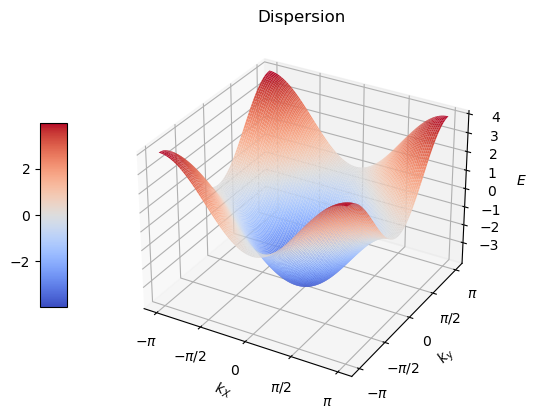

In [3]:
X = np.linspace(-np.pi, np.pi, 100)
Y = np.linspace(-np.pi, np.pi, 100)
X, Y = np.meshgrid(X, Y)
Z = -2*(np.cos(X)+np.cos(Y))

# 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlabel('$k_X$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('$E$')
ax.set_title('Dispersion')

# Set the x-axis ticks 
xticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
ax.set_xticks(xticks)
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

# Set the y-axis ticks 
yticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
ax.set_yticks(yticks)
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

cbar = fig.colorbar(surf, shrink=0.5, aspect=7, location='left')

## Approximation of Fermi Surface by SVM

In [4]:
from sklearn.svm import SVC
from matplotlib.lines import Line2D
import warnings

We define a series of functions, which will be used in our SVM models. 

In [5]:
def E(k_x, k_y): # energy formula as a function of momentum
    return -2*(np.cos(k_x)+np.cos(k_y))

In [6]:
def random_pts(N):
    """
    Returns:
    tuple: A tuple of two NumPy arrays, (k_x, k_y), where k_x and k_y contain N
    randomly generated x and y components respectively of momentum uniformly
    distributed in the interval [-π, π].
    """
    k_x = np.random.uniform(-np.pi, np.pi, size=N) 
    k_y = np.random.uniform(-np.pi, np.pi, size=N) 
    return k_x, k_y

In [7]:
def occupancy_filter(E_f, k): 
    """
    This funtion filters out occupied fermions under the Fermi energy E_f
    Args: 
        E_f (float): the Fermi energy
        k (turple): a pair of np.array of momentum
    Returns:
        np.array: an np.array of 1 and -1, where 1 indicates occupied and -1 indicates unoccupied electronic states 
    """
    k_x, k_y = k 
    energy = E(k_x, k_y)
    occupancy = (energy <= E_f)
    states = np.where(occupancy,1.,-1.)
    return states

We define the following **`approximation()`** function to generate a plot of approximation to the Fermi surface. Note that `E_f` is Fermi energy and `N` is the number of fermions used to train our SVM models. The larger the number of fermions, the better approximation to the Fermi surface. **The decision boundaries of our SVM models will be the approximation to the Fermi surface.** 

In [40]:
def approximation(E_f, N, figsize=(8, 6)):
    """
    Approximates the Fermi surface using an SVM model.

    Parameters:
    E_f (float): Fermi energy.
    N (int): Number of fermions.
    figsize (tuple, optional): The figure size. Default is (8, 6).
    """
        
    # Generate random k-points
    k_x, k_y = random_pts(N)
    
    # Compute occupancy states based on Fermi energy
    y = occupancy_filter(E_f, (k_x, k_y))
    
    # Create a dataframe with the momentums and their occupancy
    df = pd.DataFrame({'k_x': k_x, 'k_y': k_y, 'occupancy':y})
    
    # Separate the momentum and occupancy data
    momentum = df.drop('occupancy', axis = 1)
    occupancy = df['occupancy']
    
    # Train an SVM model to approximate the Fermi surface
    svm = SVC(kernel='rbf', C=1.0)
    svm.fit(momentum.values, occupancy.values)
    
    # Create a mesh of k-points to plot the Fermi surface and its approximation
    x = np.arange(-np.pi, np.pi, 0.01)
    y = x
    X, Y = np.meshgrid(x, y)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Fermi surface plot
    ax.contour(X, Y, E(X,Y), levels  = [E_f], colors='k',  linestyles='solid')
    
    # Plot the SVM-based approximation of the Fermi surface
    grid_points = np.column_stack((X.flatten(), Y.flatten()))
    grid_labels = svm.predict(grid_points).reshape(X.shape)
    ax.contourf(X, Y, grid_labels, cmap = 'coolwarm_r')
        
    # Set the x-axis ticks 
    xticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    ax.set_xticks(xticks)
    ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

    # Set the y-axis ticks 
    yticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    ax.set_yticks(yticks)
    ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

    # Add the legend
    legend_elements = [Line2D([0], [0], color='k', lw=1, label='Fermi surface')]
    plt.legend(handles = legend_elements, loc=(1.05, 0.7))
    
    ax.margins(x=0, y=0)
    plt.show()

To achieve better results, we set the number of fermions `N` to 5000.  

- $E_f = 0$

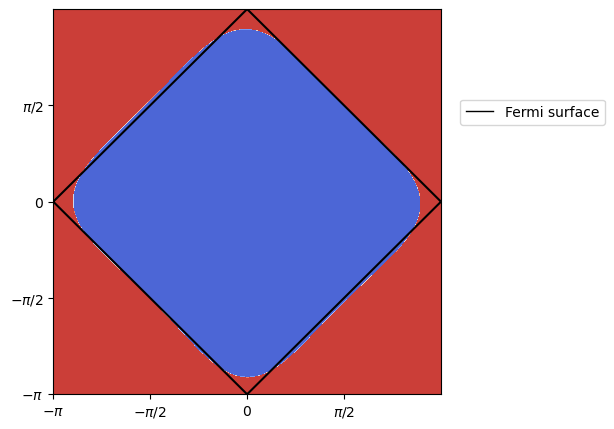

In [29]:
approximation(E_f = 0, N = 5000, figsize=(5,5))

- $E_f = 0.5$

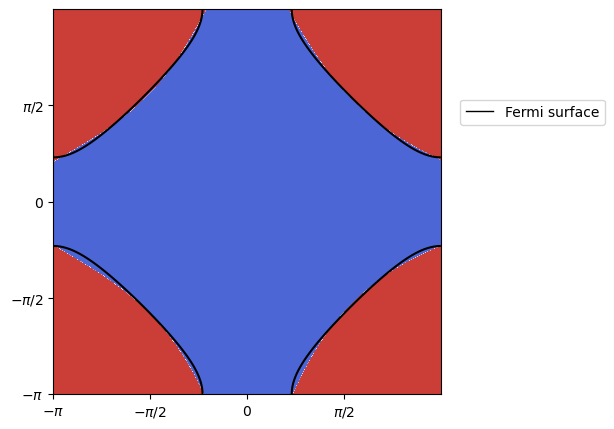

In [32]:
approximation(E_f = 0.5, N = 5000, figsize=(5,5))

- $E_f = 1$

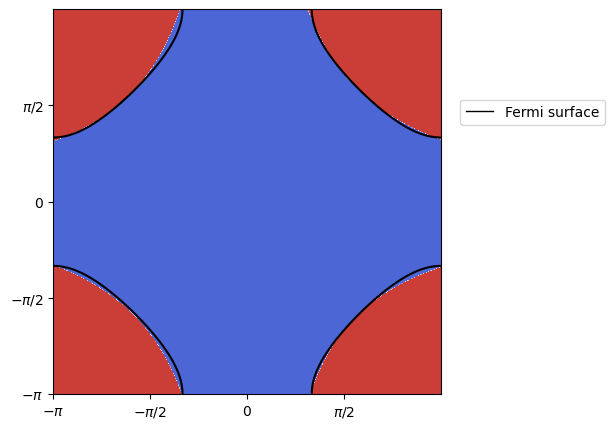

In [33]:
approximation(E_f = 1, N = 5000, figsize=(5,5))

- $E_f = 2$

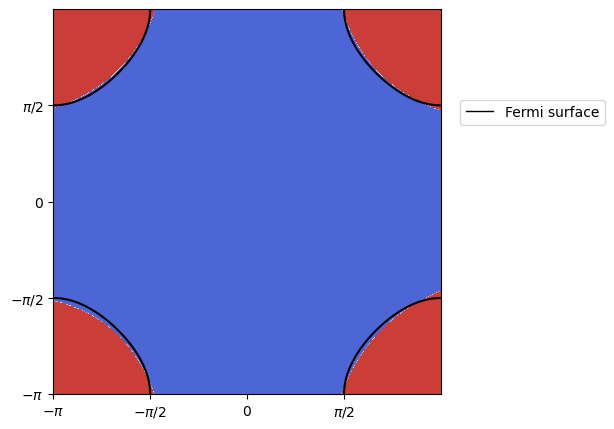

In [34]:
approximation(E_f = 2, N = 5000, figsize=(5,5))

- $E_f = 3$

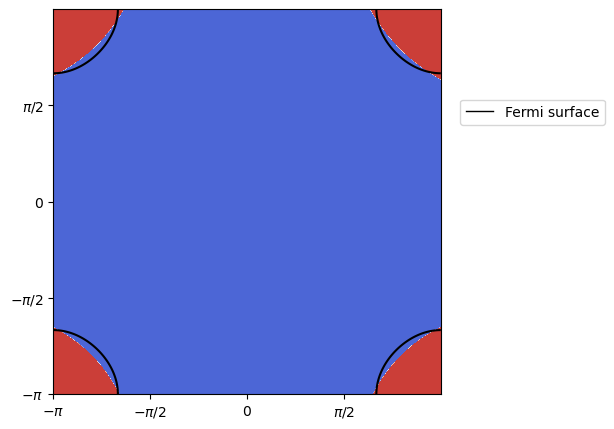

In [35]:
approximation(E_f = 3, N = 5000, figsize=(5,5))

- $E_f = -0.5$

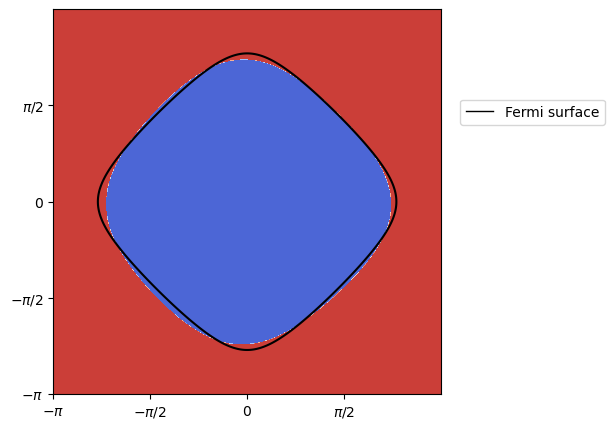

In [41]:
approximation(E_f = -0.5, N = 5000, figsize=(5,5))

- $E_f = -1$

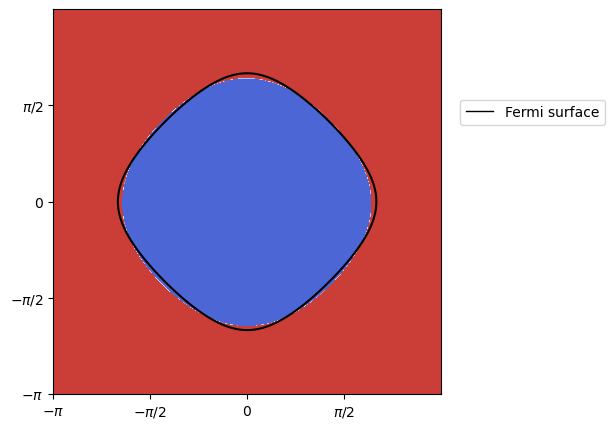

In [42]:
approximation(E_f = -1, N = 5000, figsize=(5,5))

- $E_f = -2$

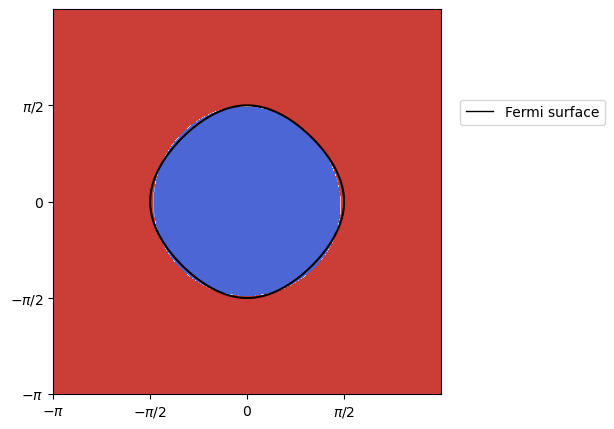

In [43]:
approximation(E_f = -2, N = 5000, figsize=(5,5))

- $E_f = -3$

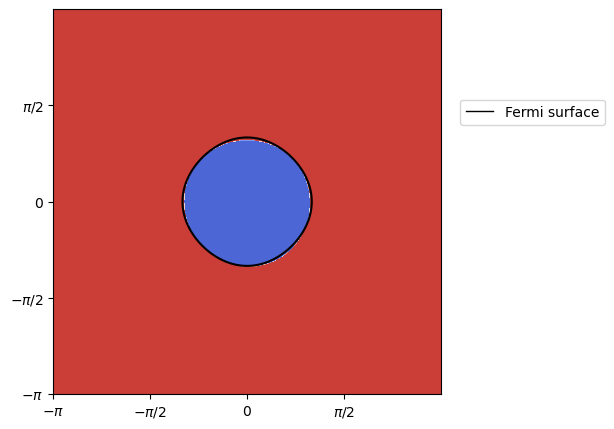

In [44]:
approximation(E_f = -3, N = 5000, figsize=(5,5))

---

<br/>